# Plot $P(1 - \sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P \vert q')$ for both the oblates and prolates in one figure

We define a correction term $\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P$ to be applied to spherically modeled velocity dispersion. For illustration purpose we plot $\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P - 1$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import csv

from copy import deepcopy
from hierarc.Util.distribution_util import PDFSampling


In [2]:
beta_const_list = [-0.2, 0, 0.2]

data_oblate = [np.load('./beta_{}_oblate.npy' .format(i)) for i in range(len(beta_const_list))]

data_prolate = [np.load('./beta_{}_prolate.npy'.format(i)) for i in range(len(beta_const_list))]

for data in data_prolate:
    data[3] = 1/data[3]
    data[4] = 1/data[4]

In [3]:
# plot the correction factor as a function of projected axis ratio
def bias_vs_qobs(sigma_axi, sigma_sph, qobs_model, qobs_measurement_list):
    """calculate the correction factor between axisymmetric and spherical JAM conditioned on the projected axis ratio

    Args:
        sigma_axi (_type_): veloity dispersion modeled with axisymmetric JAM
        sigma_sph (_type_): veloity dispersion modeled with spherical JAM
        qobs_model (_type_): projected axis ratio corresponding to each velocity dispersion model
        qobs_measurement_list (_type_): list of measured velocity dispersion (values on which the bias is conditioned)

    Returns:
        _type_: _description_
    """
    counts, bins = np.histogram(qobs_model, bins = 50, range = (qobs_model.min(), qobs_model.max() + 0.05))
    quantile = [0.16, 0.5, 0.84]
    pcs_list = []
    for qobs in qobs_measurement_list:
        bin_ind = np.digitize(qobs, bins) - 1 # find the qobs bin of the measured qobs
        bin_min, bin_max = bins[bin_ind], bins[bin_ind+1]
        real_ind = (qobs_model >= bin_min) & (qobs_model < bin_max) # retrieve the index of the velocity dispersions within the bin
        sigma_axi_binned = sigma_axi[real_ind]
        sigma_sph_binned = sigma_sph[real_ind]
        # b = (sigma_axi_binned - sigma_sph_binned) / sigma_axi_binned # calculate the bias
        b = -1 * (sigma_sph_binned - sigma_axi_binned) / sigma_sph_binned # calculate the correction 

        # calculate the median of the correction within the qobs bin
        b_counts_1d, bins_1d = np.histogram(b, bins = 30, density=True) 
        pdf_sampling = PDFSampling(bins_1d, b_counts_1d)
        b_draw = pdf_sampling.draw(100000)
        pcs = np.quantile(b_draw, q=quantile)
        pcs_list.append(pcs)
        
    return pcs_list

# calculate the correction as a function of projected axis ratio

pcs_list_both = []

for data_all in [data_oblate, data_prolate]:

    pcs_list_all = []

    for i in range(len(beta_const_list)):
        sigma_e_axi_all, sigma_e_sph_all, inc_all, qintr_all, qobs_model_all = data_all[i]
        pcs_list_all.append(bias_vs_qobs(sigma_e_axi_all, sigma_e_sph_all, qobs_model_all, qobs_model_all))

    pcs_list_both.append(pcs_list_all)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


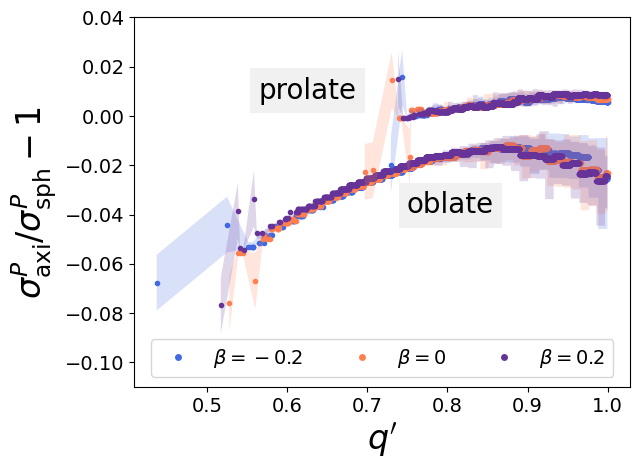

In [4]:
plt.figure()

color = ['royalblue', 'coral', 'rebeccapurple']
for j, data_all in enumerate([data_oblate, data_prolate]):

    pcs_list_all = pcs_list_both[j]

    for i in range(3):
        b_med = np.array([x[1] for x in pcs_list_all[i]])
        b_low = np.array([x[0] for x in pcs_list_all[i]])
        b_hi = np.array([x[2] for x in pcs_list_all[i]])
        q_obs = data_all[i][-1]

        sorted_indices = np.argsort(q_obs)
        q_obs = q_obs[sorted_indices]
        b_med = b_med[sorted_indices]
        b_low = b_low[sorted_indices]
        b_hi = b_hi[sorted_indices]

        plt.scatter(q_obs, b_med, marker = '.', color = color[i])
        plt.fill_between(q_obs, b_low, b_hi, alpha = 0.2, color = color[i], edgecolor = None)

plt.xlabel("$q'$", size = 24)
# plt.ylabel(r'1 - $\sigma_\mathrm{sph}^P / \sigma_\mathrm{axi}^P$', size = 24)
plt.ylabel(r'$\sigma_\mathrm{axi}^P / \sigma_\mathrm{sph}^P - 1$', size = 24)
plt.legend(prop = {'size': 18})
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(-0.11, 0.04)
# ax.grid(alpha = 0.2)

handles = []
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue', markersize=6, label=r'$\beta = -0.2$'))
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='coral', markersize=6, label=r'$\beta = 0$'))
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='rebeccapurple', markersize=6, label=r'$\beta = 0.2$'))
ax.legend(handles=handles, prop = {'size': 14}, loc='lower center', ncols=3)

props = dict(boxstyle = 'square', facecolor = 'lightgray', alpha = 0.3, edgecolor = 'None')
ax.text(0.55, 0.47, 'oblate', fontsize=20, transform = ax.transAxes, bbox = props)
ax.text(0.25, 0.78, 'prolate', fontsize=20, transform = ax.transAxes, bbox = props)


plt.savefig('../plots/bias_axi_vs_sph.pdf', bbox_inches='tight')
plt.show()